In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import numpy as np
import time
from pyDOE import lhs
import matplotlib


import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import pickle
import scipy.io
import random
from math import pi
from scipy.interpolate import griddata

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.optim import lr_scheduler

import warnings
warnings.filterwarnings("ignore")

## 超参数设置

In [3]:
import argparse
class Options_poisson(object):
    def __init__(self):
        parser = argparse.ArgumentParser()
        parser.add_argument('--no_cuda', action='store_true', default=False, help='disable CUDA or not')
        parser.add_argument('--dim_hidden', type=int, default=20, help='neurons in hidden layers') #20
        parser.add_argument('--hidden_layers', type=int, default=4, help='number of hidden layers') #4
        parser.add_argument('--lr', type=float, default=1e-3, help='initial learning rate')
        parser.add_argument('--epochs_Adam', type=int, default=10000, help='epochs for Adam optimizer')
        parser.add_argument('--epochs_LBFGS', type=int, default=0, help='epochs for LBFGS optimizer')
        parser.add_argument('--newton_iter', type=int, default=100, help='newton_iter for LBFGS optimizer')
        parser.add_argument('--step_size', type=int, default=1000, help='step size in lr_scheduler for Adam optimizer')
        parser.add_argument('--gamma', type=float, default=0.7, help='gamma in lr_scheduler for Adam optimizer')
        
        self.parser = parser

    def parse(self):
        arg = self.parser.parse_args(args=[])
        arg.cuda = not arg.no_cuda and torch.cuda.is_available()
        arg.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        return arg

args = Options_poisson().parse()
print(args.hidden_layers)

def save_model(state, is_best=None, save_dir=None):
    last_model = os.path.join(save_dir, 'last_model.pth')
    torch.save(state, last_model)
    if is_best:
        best_model = os.path.join(save_dir, 'best_model.pth')
        shutil.copyfile(last_model, best_model)
args

4


Namespace(cuda=False, device=device(type='cpu'), dim_hidden=20, epochs_Adam=10000, epochs_LBFGS=0, gamma=0.7, hidden_layers=4, lr=0.001, newton_iter=100, no_cuda=False, step_size=1000)

In [4]:
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)

def grad(outputs, inputs):
    """ compute the derivative of outputs associated with inputs

    Params
    ======
    outputs: (N, 1) tensor
    inputs: (N, D) tensor
    """
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True)

def activation(name):
    if name in ['tanh', 'Tanh']:
        return nn.Tanh()
    elif name in ['relu', 'ReLU']:
        return nn.ReLU(inplace=True)
    elif name in ['leaky_relu', 'LeakyReLU']:
        return nn.LeakyReLU(inplace=True)
    elif name in ['sigmoid', 'Sigmoid']:
        return nn.Sigmoid()
    elif name in ['softplus', 'Softplus']:
        return nn.Softplus()
    else:
        raise ValueError(f'unknown activation function: {name}')

## 网络模型(DNN)

In [5]:
class Modified_MLP(nn.Module):
    def __init__(self, dim_in, dim_out, dim_hidden, hidden_layers,
                 act_name='tanh', init_name='xavier_normal'):
        super().__init__()
        self.hidden_layers = hidden_layers

        encoder_U = nn.Sequential()
        encoder_U.add_module('fc', nn.Linear(dim_in, dim_hidden, bias=True))
        encoder_U.add_module('act', activation(act_name))
        self.encoder_U = encoder_U

        encoder_V = nn.Sequential()
        encoder_V.add_module('fc', nn.Linear(dim_in, dim_hidden, bias=True))
        encoder_V.add_module('act', activation(act_name))
        self.encoder_V = encoder_V

        model = nn.Sequential()
        model.add_module('fc0', nn.Linear(dim_in, dim_hidden, bias=True))
        model.add_module('act0', activation(act_name))
        for i in range(1, hidden_layers):
            model.add_module(f'fc{i}', nn.Linear(dim_hidden, dim_hidden, bias=True))
            model.add_module(f'act{i}', activation(act_name))
        model.add_module(f'fc{hidden_layers}', nn.Linear(dim_hidden, dim_out, bias=True))

        self.model = model
        if init_name is not None:
            self.init_weight(init_name)

        self.size = self.model_size()

    def init_weight(self, name):
        """初始化网络参数"""

        if name == 'xavier_normal':
            nn_init = nn.init.xavier_normal_
        elif name == 'xavier_uniform':
            nn_init = nn.init.xavier_uniform_
        elif name == 'kaiming_normal':
            nn_init = nn.init.kaiming_normal_
        elif name == 'kaiming_uniform':
            nn_init = nn.init.kaiming_uniform_
        else:
            raise ValueError(f'unknown initialization function: {name}')

        for param in self.parameters():
            if len(param.shape) > 1:
                nn_init(param)
    
    def forward(self, x):
        """模型的正向传播"""
        U = self.encoder_U(x)
        V = self.encoder_V(x)
        for i in range(self.hidden_layers):
            x = self.model[2 * i](x)      # 调用线性层
            x = self.model[2 * i + 1](x)  # 调用激活层
            x = (1 - x) * U + x * V       # 特征融合
        x = self.model[-1](x)             # 调用最后一个线性层得到输出
        return x

    def model_size(self):
        """模型大小"""
        n_params = 0
        for param in self.parameters():
            n_params += param.numel()
        return n_params


In [6]:
class DNN(nn.Module):
    """Deep Neural Network"""

    def __init__(self, dim_in, dim_out, dim_hidden, hidden_layers,
                 act_name='tanh', init_name=None):
        super().__init__()
        model = nn.Sequential()

        model.add_module('fc0', nn.Linear(dim_in, dim_hidden, bias=True))
        model.add_module('act0', activation(act_name))
        for i in range(1, hidden_layers):
            model.add_module(f'fc{i}', nn.Linear(dim_hidden, dim_hidden, bias=True))
            model.add_module(f'act{i}', activation(act_name))
        model.add_module(f'fc{hidden_layers}', nn.Linear(dim_hidden, dim_out, bias=True))

        self.model = model
        if init_name is not None:
            self.init_weight(init_name)

    def init_weight(self, name):
        if name == 'xavier_normal':
            nn_init = nn.init.xavier_normal_
        elif name == 'xavier_uniform':
            nn_init = nn.init.xavier_uniform_
        elif name == 'kaiming_normal':
            nn_init = nn.init.kaiming_normal_
        elif name == 'kaiming_uniform':
            nn_init = nn.init.kaiming_uniform_
        else:
            raise ValueError(f'unknown initialization function: {name}')

        for param in self.parameters():
            if len(param.shape) > 1:
                nn_init(param)

    def forward(self, x):
        return self.model(x)

    def forward_test(self, x):
        print(f"{'input':<20}{str(x.shape):<40}")
        for name, module in self.model._modules.items():
            x = module(x)
            print(f"{name:<20}{str(x.shape):<40}")
        return x

    def model_size(self):
        n_params = 0
        for param in self.parameters():
            n_params += param.numel()
        return n_params

In [7]:
model = DNN(1,1,100,2)
# model.cuda()
args.model=model
model

DNN(
  (model): Sequential(
    (fc0): Linear(in_features=1, out_features=100, bias=True)
    (act0): Tanh()
    (fc1): Linear(in_features=100, out_features=100, bias=True)
    (act1): Tanh()
    (fc2): Linear(in_features=100, out_features=1, bias=True)
  )
)

## 数据

In [8]:
class Trainset():
    def __init__(self, *args):
        self.args = args
        
    def __call__(self):
        return self.data()
    
    def u(self, x):
        Pe = 9.34
        L = 4
        C_F = 0.5
        alpha = np.sqrt(1 + 4/Pe*0.5*6)
        
        numerator = 2*(1+alpha)*np.exp(Pe/2*(1+alpha))*np.exp(Pe/2*(1-alpha)*(x/L)) - 2*(1-alpha)*np.exp(Pe/2*(1-alpha)*Pe/2*(1+alpha)*(x/L))
        denominator = (1+alpha)**2 * np.exp(Pe/2*(1+alpha)) - (1-alpha)**2 * np.exp(Pe/2*(1-alpha))
        sol = numerator / denominator * C_F
        return sol
    
    
    def data(self):
        Nsd = self.args[0]
        
        x_lb = np.array([0.0])
        x_ub = np.array([4.0])
        x = (x_ub-x_lb) * lhs(1, Nsd) + x_lb
        
        x_0 = np.array([[0.0]])
        x_L = np.array([[4.0]])
        
        x = torch.from_numpy(x).float()
        x_0 = torch.from_numpy(x_0).float()
        x_L = torch.from_numpy(x_L).float()
        
        return x, x_0, x_L

In [9]:
trainset = Trainset(500)
args.trainset = trainset
x, x_0, x_L = trainset()
args

Namespace(cuda=False, device=device(type='cpu'), dim_hidden=20, epochs_Adam=10000, epochs_LBFGS=0, gamma=0.7, hidden_layers=4, lr=0.001, model=DNN(
  (model): Sequential(
    (fc0): Linear(in_features=1, out_features=100, bias=True)
    (act0): Tanh()
    (fc1): Linear(in_features=100, out_features=100, bias=True)
    (act1): Tanh()
    (fc2): Linear(in_features=100, out_features=1, bias=True)
  )
), newton_iter=100, no_cuda=False, step_size=1000, trainset=<__main__.Trainset object at 0x0000029B1406B2B0>)

## 训练

In [10]:
class Trainer_poisson(object):
    def __init__(self, args):
        self.model = args.model
        self.lr = args.lr
        self.gamma = args.gamma

        self.newton_iter = args.newton_iter
        self.step_size = args.step_size
        
        self.model_name = self.model.__class__.__name__
        self.model_path = self._model_path()
        
        self.epochs_Adam = args.epochs_Adam
        self.epochs_LBFGS = args.epochs_LBFGS
        self.optimizer_Adam = optim.Adam(self.model.parameters(), lr=self.lr, betas=(0.9, 0.999))
        self.optimizer_LBFGS = optim.LBFGS(self.model.parameters(),
                                            lr=0.1,
                                            max_iter=self.newton_iter,
                                            tolerance_grad=1.e-5,
                                            tolerance_change=1.e-9)
        self.scheduler = lr_scheduler.ExponentialLR(self.optimizer_Adam, gamma=self.gamma, verbose=True)
                
        # data
        self.x, self.x_0, self.x_L = args.trainset()
 
        # Logger
        self.loss_log = []
        self.loss_r_log = []
        self.loss_0_log = []
        self.loss_L_log = []
        self.epoch_log = []
        self.error_log = []
        
        
    def _model_path(self):
        """Path to save the model"""
        if not os.path.exists('checkpoints'):
            os.mkdir('checkpoints')
        
        path = os.path.join('checkpoints', self.model_name)
        if not os.path.exists(path):
            os.mkdir(path)
        
        return path
    
    
    def net_r(self, x):
        x.requires_grad_(True)
        c = self.model(x)
        grad_c = grad(c, x)[0]
        c_x = grad_c[:,[0]]
        c_xx = grad(c_x, x)[0][:,[0]]
        
        residual = (16/(6*9.34))*c_xx - (4/6)*c_x - 0.5*c
        return residual
    
    
    def net_0(self, x):
        x.requires_grad_(True)
        c = self.model(x)
        grad_c = grad(c, x)[0]
        c_x = grad_c[:,[0]]
        
        residual = (4/6) * (c-0.5) - (16/(6*9.34)) * c_x
        return residual
    
    
    def net_L(self, x):
        x.requires_grad_(True)
        c = self.model(x)
        grad_c = grad(c, x)[0]
        c_x = grad_c[:,[0]]
        
        residual = c_x
        return residual        
        
    
    def net_u(self, x):
        u = self.model(x)
        
        return u
    
    
    def loss(self, use_ad=False):
        self.r_pred = self.net_r(self.x)
        self.r_0_pred = self.net_0(self.x_0)
        self.r_L_pred = self.net_L(self.x_L)
        loss_r = torch.mean(self.r_pred**2)
        loss_0 = torch.mean(self.r_0_pred**2)
        loss_L = torch.mean(self.r_L_pred**2)

        loss = loss_r + 100*loss_0 + 100*loss_L
        return loss, loss_r, loss_0, loss_L
    
    
    def train_Adam(self):
        self.optimizer_Adam.zero_grad()

        loss_value, loss_r_value, loss_0_value, loss_L_value = self.loss()
        loss_value.backward()
        self.optimizer_Adam.step()

        return loss_value.item(), loss_r_value.item(), loss_0_value.item(), loss_L_value.item()

        

    def train_LBFGS(self):
        loss_value, loss_r_value, loss_0_value, loss_L_value = self.loss()
        
        def closure():
            loss_value, loss_r_value, loss_0_value, loss_L_value = self.loss()

            self.optimizer_LBFGS.zero_grad()
            loss_value.backward()

            return loss_value

        self.optimizer_LBFGS.step(closure)
        loss_value = closure()
        
        return loss_value.item(), loss_r_value.item(), loss_0_value.item(), loss_L_value.item()
    
    
    def validate(self, epoch):
        self.model.eval()
        loss_value, loss_r_value, loss_0_value, loss_L_value = self.loss()
        
        infos = 'Valid   ' + \
                f'Loss:{loss_value:.4e}  ' + \
                f'Loss_r:{loss_r_value:.4e} '
        print(infos)
        self.model.train()
        return loss_value.item()

    
    def train(self):
        start = time.time()
        best_loss = 1.e10
                 
        for epoch in range(self.epochs_Adam):
            loss_value, loss_r_value, loss_0_value, loss_L_value = self.train_Adam()
            
            if (epoch+1) % self.step_size == 0:
                self.scheduler.step()         
            
            if (epoch+1) % 100 == 0:
                self.loss_log.append(loss_value)
                self.loss_r_log.append(loss_r_value)
                self.loss_0_log.append(loss_0_value)
                self.loss_L_log.append(loss_L_value)
                self.epoch_log.append(epoch)
                
                running_time = time.time() - start
                start = time.time()
                
                print(f'Epoch #  {epoch+1}/{self.epochs_Adam}' + f'    time:{running_time:.2f}' + '\n' + \
                      f'loss:{loss_value:.2e}, loss_r:{loss_r_value:.2e}, loss_0:{loss_0_value:.2e}, loss_L:{loss_L_value:.2e}')  
                
                valid_loss = self.validate(epoch)
                is_best = valid_loss < best_loss
                state = {
                    'epoch': epoch,
                    'state_dict': self.model.state_dict(),
                    'best_loss': best_loss
                }
                save_model(state, is_best, save_dir=self.model_path)  

In [11]:
%%time 
trainer = Trainer_poisson(args)
trainer.train()

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch #  100/10000    time:0.59
loss:2.18e-03, loss_r:1.96e-03, loss_0:2.18e-06, loss_L:9.78e-10
Valid   Loss:2.0271e-03  Loss_r:1.9613e-03 
Epoch #  200/10000    time:0.65
loss:1.47e-03, loss_r:1.47e-03, loss_0:4.19e-09, loss_L:2.33e-09
Valid   Loss:1.4688e-03  Loss_r:1.4682e-03 
Epoch #  300/10000    time:0.59
loss:1.13e-03, loss_r:1.13e-03, loss_0:2.12e-09, loss_L:9.73e-09
Valid   Loss:1.1304e-03  Loss_r:1.1292e-03 
Epoch #  400/10000    time:0.54
loss:9.27e-04, loss_r:9.25e-04, loss_0:1.50e-09, loss_L:1.71e-08
Valid   Loss:9.2501e-04  Loss_r:9.2315e-04 
Epoch #  500/10000    time:0.49
loss:7.86e-04, loss_r:7.84e-04, loss_0:1.11e-09, loss_L:2.11e-08
Valid   Loss:7.8461e-04  Loss_r:7.8239e-04 
Epoch #  600/10000    time:0.47
loss:6.71e-04, loss_r:6.69e-04, loss_0:8.56e-10, loss_L:2.17e-08
Valid   Loss:6.6970e-04  Loss_r:6.6745e-04 
Epoch #  700/10000    time:0.47
loss:5.68e-04, loss_r:5.66e-04, loss_0:6.79e-10, loss_L:2.01e-08
Valid  

Epoch #  5700/10000    time:0.46
loss:4.90e-05, loss_r:4.90e-05, loss_0:4.26e-12, loss_L:5.06e-10
Valid   Loss:4.8997e-05  Loss_r:4.8946e-05 
Epoch #  5800/10000    time:0.48
loss:4.83e-05, loss_r:4.83e-05, loss_0:3.81e-12, loss_L:5.01e-10
Valid   Loss:4.8326e-05  Loss_r:4.8276e-05 
Epoch #  5900/10000    time:0.47
loss:4.76e-05, loss_r:4.76e-05, loss_0:3.78e-12, loss_L:4.96e-10
Valid   Loss:4.7636e-05  Loss_r:4.7586e-05 
Adjusting learning rate of group 0 to 1.1765e-04.
Epoch #  6000/10000    time:0.47
loss:4.69e-05, loss_r:4.69e-05, loss_0:4.32e-12, loss_L:4.88e-10
Valid   Loss:4.6927e-05  Loss_r:4.6878e-05 
Epoch #  6100/10000    time:0.47
loss:4.64e-05, loss_r:4.64e-05, loss_0:3.96e-12, loss_L:4.84e-10
Valid   Loss:4.6416e-05  Loss_r:4.6367e-05 
Epoch #  6200/10000    time:0.47
loss:4.59e-05, loss_r:4.58e-05, loss_0:3.78e-12, loss_L:4.79e-10
Valid   Loss:4.5888e-05  Loss_r:4.5840e-05 
Epoch #  6300/10000    time:0.46
loss:4.53e-05, loss_r:4.53e-05, loss_0:3.55e-12, loss_L:4.74e-10


In [12]:
file = f'checkpoints/subnet,{args.epochs_Adam}Adam,{args.epochs_LBFGS}LBFGS'
if os.path.exists(file)==False:
    os.mkdir(file)

In [13]:
np.save(f'{file}/loss_r_log.npy',np.array(trainer.loss_r_log))
np.save(f'{file}/loss_0_log.npy',np.array(trainer.loss_0_log))
np.save(f'{file}/loss_L_log.npy',np.array(trainer.loss_L_log))
np.save(f'{file}/epoch_log.npy',np.array(trainer.epoch_log))
np.save(f'{file}/error_log.npy',np.array(trainer.error_log))

## 预测

In [14]:
# 使用最好的模型
state_dict = torch.load(f'{trainer.model_path}/best_model.pth')
model.load_state_dict(state_dict['state_dict'])

<All keys matched successfully>

In [15]:
model.cpu();

In [16]:
def predict(X):
    
    X_star = torch.from_numpy(X.flatten()[:,None]).float()

    u_star = model(X_star)

    u_star = trainer.net_u(X_star)
    r_star = trainer.net_r(X_star)

    return u_star.detach().numpy(), r_star.detach().numpy()

In [17]:
nx = 512
x = np.linspace(0, 4, nx)
u_star = trainset.u(x)
u_star = u_star.reshape(-1,1)

u_pred, f_u_pred = predict(x)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)

print('Error u: %e' % (error_u))

Error u: 1.735538e-02


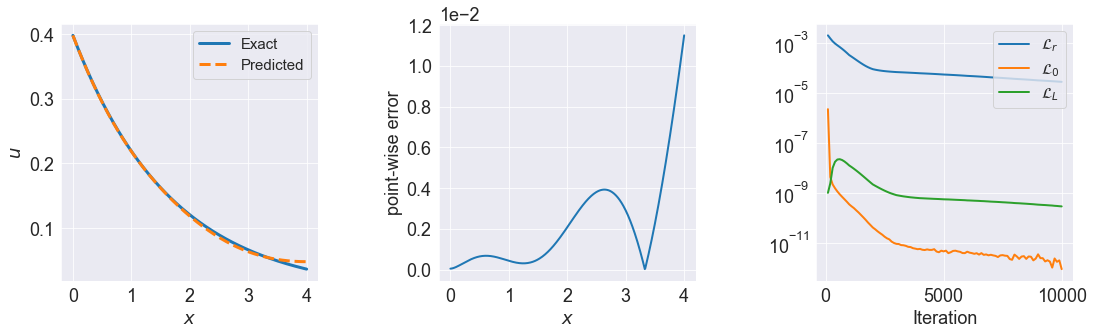

In [18]:
plt.rcParams.update({'font.size':18})
with sns.axes_style("darkgrid"):
    fig = plt.figure(3, figsize=(16, 5))
    ax = plt.subplot(1, 3, 1)
    plt.plot(x, u_star, label='Exact', linewidth=3)
    plt.plot(x, u_pred, '--', label='Predicted', linewidth=3)
    plt.xlabel('$x$')
    plt.ylabel('$u$')
    plt.xticks([0, 1, 2, 3, 4])
    plt.legend(loc='upper right', fontsize=15)
    plt.tight_layout()
    ax.set_aspect(1./ax.get_data_ratio())

    ax = plt.subplot(1, 3, 2)
    plt.plot(x, np.abs(u_star-u_pred), linewidth=2)
    plt.xlabel('$x$')
    plt.ylabel('point-wise error')
    plt.xticks([0, 1, 2, 3, 4])
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.tight_layout()
    ax.set_aspect(1./ax.get_data_ratio())

    ax = plt.subplot(1, 3, 3)
    plt.plot(trainer.epoch_log, trainer.loss_r_log, label='$ \mathcal{L}_r$', linewidth=2)
    plt.plot(trainer.epoch_log, trainer.loss_0_log, label='$ \mathcal{L}_0$', linewidth=2)
    plt.plot(trainer.epoch_log, trainer.loss_L_log, label='$ \mathcal{L}_L$', linewidth=2)
    plt.xlabel('Iteration')
    plt.yscale('log')
    plt.legend(loc='upper right', fontsize=15)
    ax.set_aspect(1./ax.get_data_ratio())
    
    plt.savefig(f'{file}/results_1D_poisson.png', dpi=96, bbox_inches = 'tight')
    plt.show()